# First ICU & 5 Day Discharge Prediction using Random Forests

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import pandas as pd
import pickle
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from utils.splits import set_two_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *
from args import args
vars(args)

{'path': PosixPath('../data'),
 'workdir': PosixPath('../data/workdir/rf'),
 'dataset_csv': PosixPath('../data/mimic_icu_pred_proc_dataset.csv'),
 'cols': ['imminent_label', 'discharge_label', 'scispacy_note'],
 'modeldir': PosixPath('../data/workdir/rf/models'),
 'min_freq': 3,
 'imminent_threshold': 0.32,
 'discharge_threshold': 0.37,
 'start_seed': 127}

In [3]:
seed = 42
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols)

imminent_df = ori_df.loc[(ori_df['imminent_label'] != -1)][['scispacy_note', 'imminent_label']].reset_index()
discharge_df = ori_df[['scispacy_note', 'discharge_label']].reset_index()

print(imminent_df.shape)
print(discharge_df.shape)

(50809, 3)
(75271, 3)


## RF Model Dev

### Imminent ICU Admission

In [4]:
df = set_two_splits(imminent_df.copy(), 'test', seed=seed)
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])
y_train = df.loc[(df['split'] == 'train')]['imminent_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['imminent_label'].to_numpy()

In [5]:
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50809, 4), (43187, 57025), (7622, 57025), (43187,), (7622,))

In [6]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

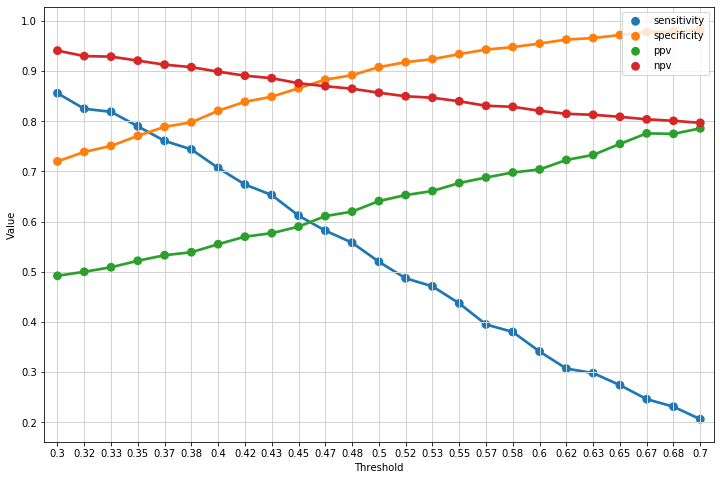

In [7]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, y_test, prob, 0.3, 0.7, 25)

In [8]:
args.imminent_threshold = 0.32
y_pred = (prob > args.imminent_threshold).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.825
specificity,0.739
ppv,0.500
npv,0.930
f1,0.623
auroc,0.861
prevalence,0.240


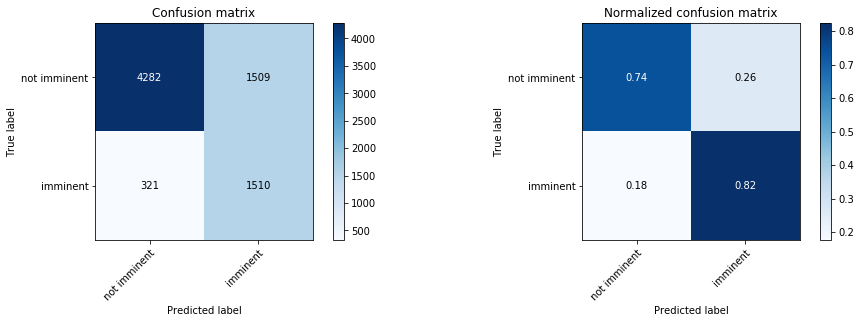

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_confusion_matrix(ax[0], cm, classes=['not imminent', 'imminent'], normalize=False, title='Confusion matrix')
plot_confusion_matrix(ax[1], cm, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized confusion matrix')
plt.show()

In [10]:
scores = clf.feature_importances_ / clf.feature_importances_.sum()

Text(0.5, 1.0, 'Positive Class')

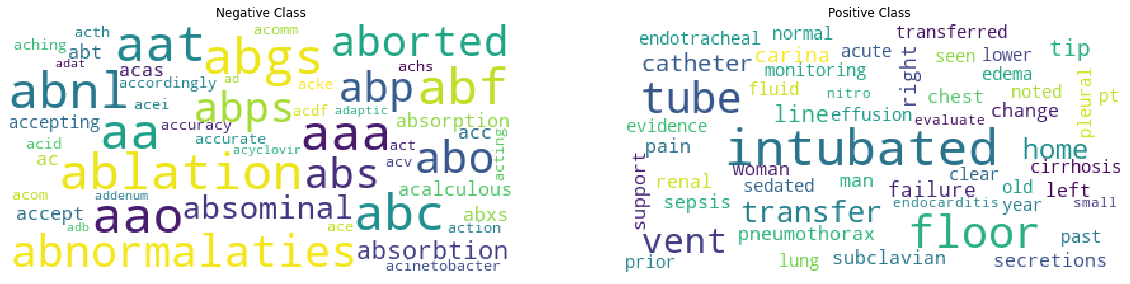

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')

### ICU Discharge

In [12]:
df = set_two_splits(discharge_df.copy(), 'test', seed=seed)
vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])
y_train = df.loc[(df['split'] == 'train')]['discharge_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['discharge_label'].to_numpy()

In [13]:
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((75271, 4), (63980, 66756), (11291, 66756), (63980,), (11291,))

In [14]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

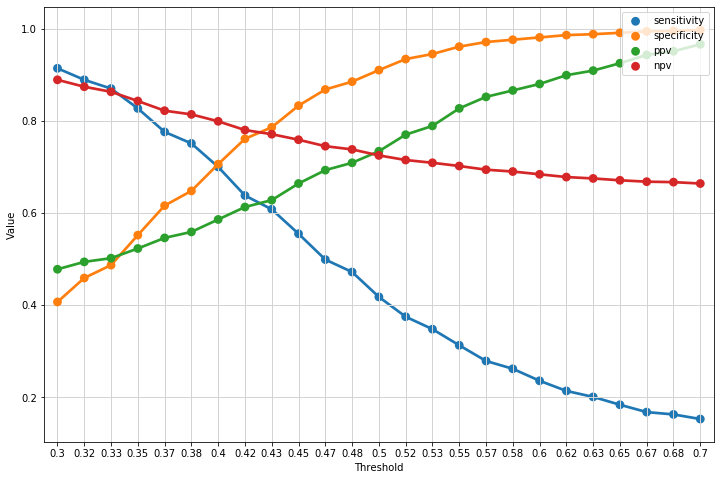

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
plot_thresh_range(ax, y_test, prob, 0.3, 0.7, 25)

In [16]:
args.discharge_threshold = 0.37
y_pred = (prob > args.discharge_threshold).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.776
specificity,0.616
ppv,0.546
npv,0.822
f1,0.641
auroc,0.787
prevalence,0.373


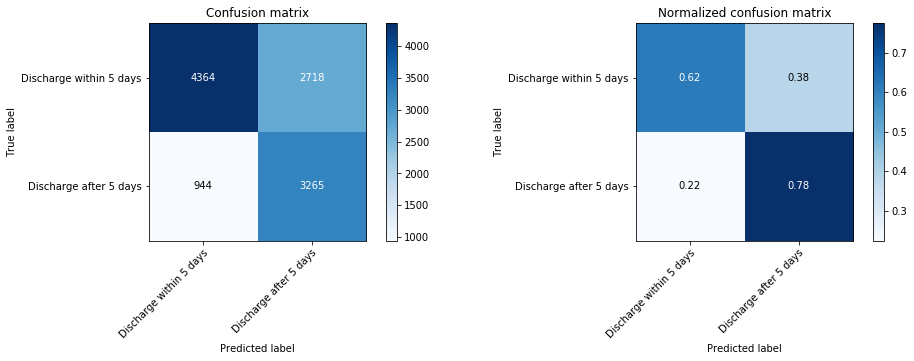

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_confusion_matrix(ax[0], cm, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=False, title='Confusion matrix')
plot_confusion_matrix(ax[1], cm, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=True, title='Normalized confusion matrix')
plt.show()

In [18]:
scores = clf.feature_importances_ / clf.feature_importances_.sum()

Text(0.5, 1.0, 'Positive Class')

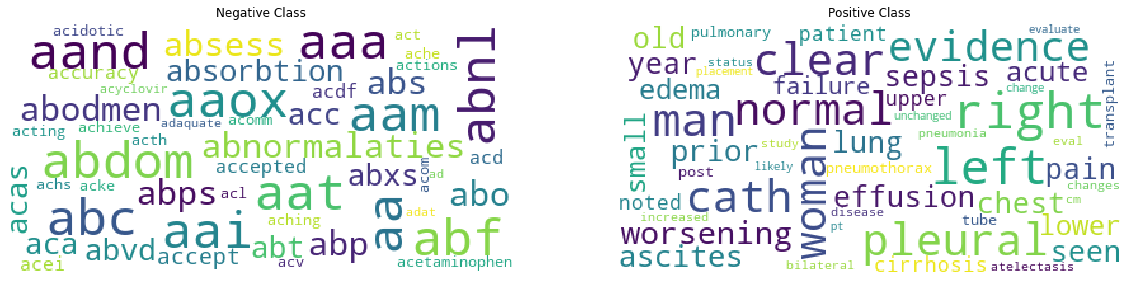

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), clf.feature_importances_, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')

## 100 Seed Run

In [ ]:
def run(task, ori_df, threshold):
  preds = []
  targs = []
  probs = []
  print(f"Running for task: {task}")

  for seed in range(args.start_seed, args.start_seed + 100):
    if seed % 10 == 0:
      print(f"Running classifier with seed {seed}")
    df = set_two_splits(ori_df.copy(), 'test', seed=seed)
    vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, ngram_range=(2,2))

    x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['scispacy_note'])
    x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['scispacy_note'])

    y_train = df.loc[(df['split'] == 'train')][f'{task}_label'].to_numpy()
    y_test = df.loc[(df['split'] == 'test')][f'{task}_label'].to_numpy()
    targs.append(y_test)

    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, min_samples_leaf=3, max_features=0.5, oob_score=True)
    clf.fit(x_train, y_train)  
    pickle.dump(clf, open(args.modeldir/f'{task}_seed_{seed}.pkl', 'wb'))

    pos_prob = clf.predict_proba(x_test)[:, 1]
    probs.append(pos_prob)

    y_pred = (pos_prob > threshold).astype(np.int64)
    preds.append(y_pred)

  with open(args.workdir/f'{task}_preds.pkl', 'wb') as f:
    pickle.dump(targs, f)
    pickle.dump(preds, f)
    pickle.dump(probs, f)

In [ ]:
run('imminent', imminent_df, args.imminent_threshold)
run('discharge', discharge_df, args.discharge_threshold)

## Metrics

Taken from [here](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/):

1. Prevalence: `(fn + tp) / total`
2. Sensitivity: AKA recall, true positive rate `tp / (tp + fn)`
3. Specificity: AKA true negative rate `tn / (tn + fp)`
4. Positive Predictive Value (PPV): AKA precision `tp / (tp + fp)`
5. Negative Predictive Value (NPV): `tn / (tn + fn)`

In [ ]:
with open(args.workdir/f'imminent_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

bam_imminent = BinaryAvgMetrics(targs, preds, probs)

with open(args.workdir/f'discharge_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

bam_discharge = BinaryAvgMetrics(targs, preds, probs)

fnames_imminent = [f'imminent_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
fnames_discharge = [f'discharge_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]

In [ ]:
bam_imminent.get_avg_metrics(conf=0.95)

In [ ]:
get_best_model(bam_imminent, fnames_imminent)

In [ ]:
bam_discharge.get_avg_metrics(conf=0.95)

In [ ]:
get_best_model(bam_discharge, fnames_discharge)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam_imminent.targs, bam_imminent.probs)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam_discharge.targs, bam_discharge.probs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam_imminent.cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam_imminent.cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bam_imminent.cm_avg, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bam_imminent.cm_avg, classes=['Discharge within 5 days', 'Discharge after 5 days'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

## Full Data

In [ ]:
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols)

imminent_df = ori_df.loc[(ori_df['imminent_label'] != -1)][['scispacy_note', 'imminent_label']].reset_index()
discharge_df = ori_df[['scispacy_note', 'discharge_label']].reset_index()

In [ ]:
with open(args.workdir/'all_data_model.pkl', 'wb') as f:
  pickle.dump(clf, f)
  pickle.dump(vectorizer.vocabulary_, f)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_prob(ax, df, args.bc_threshold, cutoff=20, interval=12)